# Import packages & functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import umap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import OpenClipper, Clipper, BrainNetwork, BrainDiffusionPrior, Voxel2StableDiffusionModel

seed=42
utils.seed_everything(seed=seed)

# Load CLIP extractor
# clip_extractor = Clipper("ViT-L/14", device=device)
clip_extractor = OpenClipper("ViT-H-14", device=device)

device: cuda
ViT-H-14 cuda


# Load models

In [9]:
model_name = "v2c_openclip_H14_img" 

# model_name = "v2c_H14_image_withmse_nonorm"

outdir = f'../train_logs/{model_name}'

ckpt_path = os.path.join(outdir, f'best.pth')
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)

ckpt_path ../train_logs/v2c_openclip_H14_img/best.pth


### Load pretrained weights onto model

In [10]:
voxel2clip = BrainNetwork(out_dim=1024)
print("converting ddp model to non-ddp format")
state_dict = checkpoint['model_state_dict']
for key in list(state_dict.keys()):
    if 'module.' in key:
        state_dict[key.replace('module.', '')] = state_dict[key]
        del state_dict[key]
voxel2clip.load_state_dict(state_dict)
voxel2clip.to(device)

converting ddp model to non-ddp format


BrainNetwork(
  (lin0): Sequential(
    (0): Linear(in_features=15724, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [11]:
# voxel2clip = BrainNetwork(out_dim=1024) #768

# # need folder "checkpoints" with following files
# # wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# # wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
# diffusion_prior = BrainDiffusionPrior.from_pretrained(
#     dict(),
#     dict(
#         condition_on_text_encodings=False,
#         timesteps=1000,
#         voxel2clip=voxel2clip,
#     ),
# )

# # try:
# #     diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
# #     diffusion_prior.eval().to(device)
# # except:
# #     print("converting ddp model to non-ddp format")
# #     state_dict = checkpoint['model_state_dict']
# #     for key in list(state_dict.keys()):
# #         if 'module.' in key:
# #             state_dict[key.replace('module.', '')] = state_dict[key]
# #             del state_dict[key]
# #     diffusion_prior.load_state_dict(state_dict)#,strict=False)
# #     diffusion_prior.eval().to(device)
    
    
# model_name = "v2c_openclip_H14_img"
# outdir = f'../train_logs/{model_name}'
# ckpt_path = os.path.join(outdir, f'best.pth')
# print("ckpt_path",ckpt_path)
# checkpoint = torch.load(ckpt_path, map_location=device)
# try:
#     diffusion_prior.voxel2clip.load_state_dict(checkpoint['model_state_dict'])
#     diffusion_prior.voxel2clip.eval().to(device)
# except:
#     print("converting ddp model to non-ddp format")
#     state_dict = checkpoint['model_state_dict']
#     for key in list(state_dict.keys()):
#         if 'module.' in key:
#             state_dict[key.replace('module.', '')] = state_dict[key]
#             del state_dict[key]
#     diffusion_prior.voxel2clip.load_state_dict(state_dict)
#     diffusion_prior.voxel2clip.eval().to(device)

# diffusion_prior.eval().to(device)
# print("loaded")

# CLIP retrieval evaluation

### Prep data loader

In [12]:
batch_size = 300 # same as used in mind_reader

# train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
num_train = 8559 + 300
num_val = 982

val_batch_size = 300
val_loops = 10

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

val_data = wds.WebDataset(val_url, resampled=True)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "trial")\
    .batched(val_batch_size, partial=False)\
    .with_epoch(val_loops)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, trial) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([300, 3, 15724])
img_input.shape torch.Size([300, 3, 256, 256])


## Forward / Backward quantification

In [13]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=val_loops)):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions
            # voxel = voxel[:,0].to(device) # use first repetition
            
            emb = clip_extractor.embed_image(img) # CLIP-Image
            
            #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text
            
            # l2norm 
            emb_ = nn.functional.normalize(voxel2clip(voxel),dim=-1) 
            # emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) 
            # emb_ *= diffusion_prior.voxel2clip.image_embed_scale  # PS: dont use, its for prior
            
            labels = torch.arange(len(emb)).to(device)
            bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
            fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
            
            assert len(bwd_sim) == batch_size

            if percent_correct_fwd is None:
                cnt=len(fwd_sim)
                percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            else:
                cnt+=len(fwd_sim)
                percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
print("cnt",cnt,"val_i",val_i)
percent_correct_fwd /= val_i
percent_correct_bwd /= val_i
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

100%|███████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.58s/it]

cnt 3000 val_i 9
fwd percent_correct tensor(0.6922, device='cuda:0')
bwd percent_correct tensor(0.6830, device='cuda:0')


### Plot some of the results

Forward retrieval
Aka given Brain embedding, find correct CLIP embedding


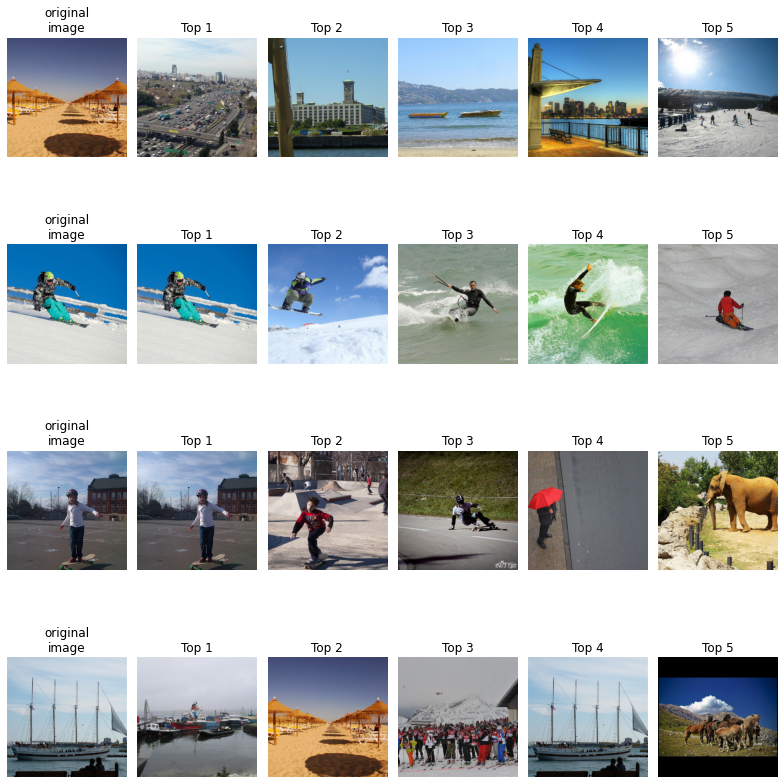

In [14]:
print("Forward retrieval")
print("Aka given Brain embedding, find correct CLIP embedding")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval
Aka given CLIP embedding, find correct Brain embedding


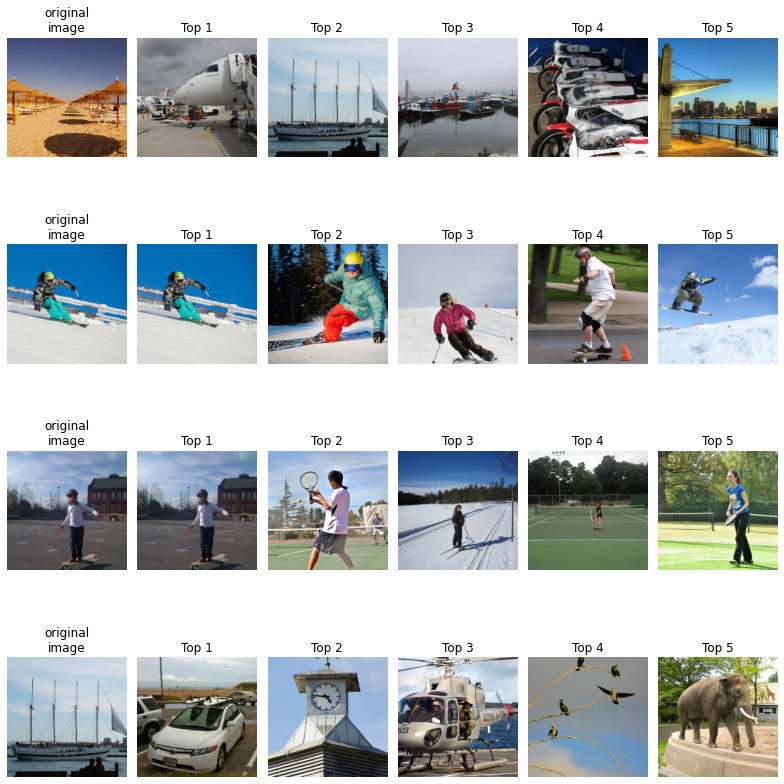

In [15]:
print("Backward retrieval")
print("Aka given CLIP embedding, find correct Brain embedding")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

### 2AFC

In [120]:
per_correct=[]
for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val)):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            if val_i == 0:
                prev = torch.mean(voxel,axis=1).to(device)
                continue
            
            voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions
            # voxel = voxel[:,0].to(device) # use first repetition
            
            fake = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1)
            
            real = clip_extractor.embed_image(img) # CLIP-Image
            
            rand = nn.functional.normalize(diffusion_prior.voxel2clip(prev),dim=-1)
            
            # cosine similarity is faster and gives same results
            l2dist_fake = utils.pairwise_cosine_similarity(real,fake).item()
            l2dist_rand = utils.pairwise_cosine_similarity(real,rand).item()

            if l2dist_fake > l2dist_rand:
                per_correct.append(1)
            else:
                per_correct.append(0)
                
            prev = voxel.clone()
                
print(np.mean(per_correct))

  1%|▌                                                                | 8/982 [00:00<00:26, 36.24it/s]

torch.Size([1, 15724])


100%|███████████████████████████████████████████████████████████████| 982/982 [00:28<00:00, 34.15it/s]


0.9938837920489296


# Reconstruction evaluation

In [11]:
image_var = 'images'
# train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
num_train = 8559 + 300
num_val = 982

val_batch_size = 1

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "trial")\
    .batched(val_batch_size, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, trial) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([1, 3, 15724])
img_input.shape torch.Size([1, 3, 256, 256])


### Load SD variations model

In [12]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

sd_cache_dir = '/fsx/proj-medarc/fmri/cache/models--stabilityai--stable-diffusion-2-1-unclip/snapshots/5eaf116f1b118d1756d5df9f578e8259befa95b7'

unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet").to(device)
unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
vae.eval()
vae.requires_grad_(False)

scheduler = "unipc" # "pndms" or "unipc"

noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
if scheduler == "unipc":
    noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)
    num_inference_steps = 20
else:
    num_inference_steps = 50

# from diffusers import StableUnCLIPImg2ImgPipeline
# sd_pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
#     sd_cache_dir, torch_dtype=torch.float16,
# ).to(device)
prompt_embeds0 = torch.load('prompt_embeds.pt').to(device)

The config attributes {'class_embeddings_concat': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
# from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

# sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
# # sd_cache_dir = '/scratch/gpfs/KNORMAN/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
# if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
#     from diffusers import StableDiffusionImageVariationPipeline
#     print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
#     sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", revision="v2.0")
#     sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

# unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet").to(device)
# unet.eval() # dont want to train model
# unet.requires_grad_(False) # dont need to calculate gradients

# vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
# vae.eval()
# vae.requires_grad_(False)

# scheduler = "unipc" # "pndms" or "unipc"

# noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
# if scheduler == "unipc":
#     noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)
#     num_inference_steps = 20
# else:
#     num_inference_steps = 50

# pass

## Check autoencoder works

In [9]:
voxel2sd = Voxel2StableDiffusionModel()
state_dict = torch.load('../train_logs/models/autoencoder/test/ckpt-epoch120.pth', 
                        map_location='cpu')["model_state_dict"]
# for key in list(state_dict.keys()):
#     if 'module.' in key:
#         state_dict[key.replace('module.', '')] = state_dict[key]
#         del state_dict[key]
voxel2sd.load_state_dict(state_dict)#,strict=False)
voxel2sd.eval()
voxel2sd.to(device)
pass

In [8]:
# voxels, images, _ = next(iter(val_dl))
# voxels = torch.mean(voxels,axis=1)

# with torch.no_grad():
#     preds = voxel2sd(voxels.float().to(device))
#     reconst = vae.decode(preds.to(device)/0.18215).sample

# for b in range(len(voxels)):
#     plt.imshow(utils.torch_to_Image(((reconst[b]/2 + 0.5)*255).byte()))
#     plt.show()
#     plt.imshow(utils.torch_to_Image((images[b]*255).byte()))
#     plt.show()

## Reconstruction via diffusion, one at a time
This will take awhile!!

In [15]:
# import os
# import sys
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import transforms
# from tqdm import tqdm
# from datetime import datetime
# import webdataset as wds

# start = 109 * int(0)
# end = start + 109
# print("start", start, "end", end)

# image_var = 'images'
# # train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
# val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
# meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
# num_train = 8559 + 300
# num_val = 982

# val_batch_size = 1

# voxels_key = 'nsdgeneral.npy' # 1d inputs

# val_data = wds.WebDataset(val_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "trial")\
#     .batched(val_batch_size, partial=False)

# val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
# all_images = None
# all_clip_recons = None
# all_brain_recons = None
# all_laion_picks = None

# recons_per_clip = 0
# recons_per_brain = 8

# img2img = True
# retrieve = False
# plotting = False

# batch_size = 1
# assert batch_size == 1

# for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val)):
#     if (val_i!=num_val-1) and (val_i < start or val_i >= end):
#         continue
#     print(val_i)

### KNN only

2023-03-30 13:53:39


  0%|                                                        | 1/982 [00:43<11:51:07, 43.49s/it]


RuntimeError: shape '[-1, 3, 512, 512]' is invalid for input of size 3538944

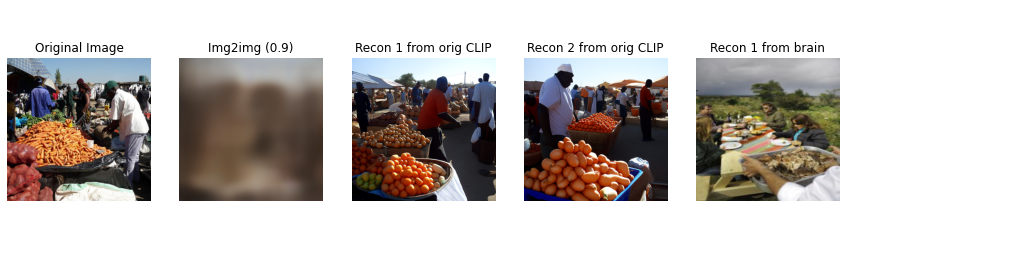

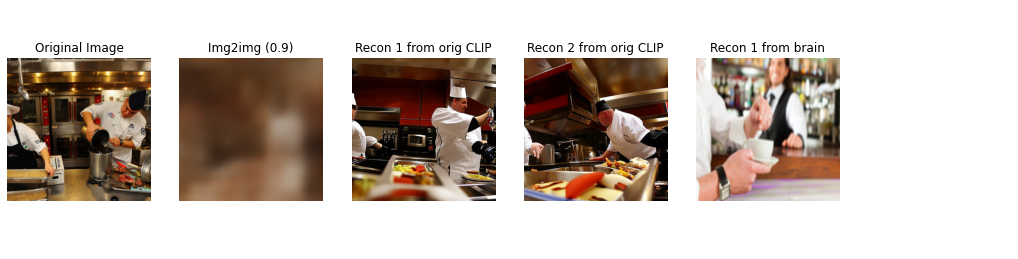

In [18]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
all_laion_picks = None

recons_per_clip = 0
recons_per_brain = 0

img2img = True
retrieve = True
plotting = True

batch_size = 1
assert batch_size == 1

for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val)):
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    img = img[[0]]
    with torch.no_grad():
        if img2img:
            ae_preds = voxel2sd(voxel.float())
            blurry_recons = vae.decode(ae_preds.to(device)/0.18215).sample / 2 + 0.5
        else:
            blurry_recons = None
            
        if not openclip:
            grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_clip(
                img, voxel,
                diffusion_prior, 
                clip_extractor, unet, vae, noise_scheduler,
                prompt_embeds0,
                img_lowlevel = blurry_recons,
                num_inference_steps = num_inference_steps,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .9, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps = 1000,
                seed = seed,
                retrieve = retrieve,
                plotting = plotting,
            )
        else:
            grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_openclip(
                img, voxel,
                voxel2clip, 
                clip_extractor, unet, vae, noise_scheduler,
                prompt_embeds0,
                img_lowlevel = blurry_recons,
                num_inference_steps = num_inference_steps,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .9, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps = 1000,
                seed = seed,
                retrieve = retrieve,
                plotting = plotting,
            )

        if plotting:
            grid.savefig(f'evals/{model_name}_{val_i}_{scheduler}.png')
            # plt.close()

        if clip_recons is not None:
            clip_recons = clip_recons[:,0]
        if brain_recons is not None:
            brain_recons = brain_recons[:,int(laion_best_picks)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            if recons_per_brain > 0 or retrieve:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            if recons_per_clip > 0:
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))
    if val_i>=1:
        break
                    
if recons_per_brain > 0 or retrieve:
    if recons_per_brain>0:
        all_brain_recons = all_brain_recons.view(-1,3,512,512)
    else:
        all_brain_recons = all_brain_recons.view(-1,3,512,512)
if recons_per_clip > 0:
    all_clip_recons = all_clip_recons.view(-1,3,512,512)

print("all_images.shape",all_images.shape)
if recons_per_brain > 0 or retrieve:
    print("all_brain_recons.shape",all_brain_recons.shape)
if recons_per_clip > 0: 
    print("all_clip_recons.shape",all_clip_recons.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

## Recon

In [11]:
# print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
# all_images = None
# all_clip_recons = None
# all_brain_recons = None
# all_laion_picks = None

# recons_per_clip = 1
# recons_per_brain = 1

# img2img = False
# retrieve = False
# plotting = True

# batch_size = 1
# assert batch_size == 1

# for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val)):
#     voxel = torch.mean(voxel,axis=1).to(device)
#     # voxel = voxel[:,0].to(device)
#     img = img[[0]]
#     with torch.no_grad():
#         with torch.cuda.amp.autocast():
#             if img2img:
#                 ae_preds = voxel2sd(voxel.float())
#                 blurry_recons = vae.decode(ae_preds.to(device)/0.18215).sample / 2 + 0.5
#             else:
#                 blurry_recons = None

#             grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_clip(
#                 img, voxel,
#                 diffusion_prior, 
#                 clip_extractor, unet, vae, noise_scheduler,
#                 img_lowlevel = blurry_recons,
#                 num_inference_steps = num_inference_steps,
#                 n_samples_save = batch_size,
#                 recons_per_clip = recons_per_clip,
#                 recons_per_brain = recons_per_brain,
#                 guidance_scale = 7.5,
#                 img2img_strength = .9, # 0=fully rely on img_lowlevel, 1=not doing img2img
#                 timesteps = 1000,
#                 seed = seed,
#                 retrieve = retrieve,
#                 plotting = plotting,
#             )
            
#             if plotting:
#                 grid.savefig(f'evals/{model_name}_{val_i}_{scheduler}_reimagine.png')
#                 #plt.close()
                
#             if clip_recons is not None:
#                 clip_recons = clip_recons[:,0]
#             if brain_recons is not None:
#                 brain_recons = brain_recons[:,int(laion_best_picks)]
            
#             if all_brain_recons is None:
#                 all_brain_recons = brain_recons
#                 all_clip_recons = clip_recons
#                 all_images = img
#             else:
#                 if recons_per_brain > 0 or retrieve:
#                     all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
#                 if recons_per_clip > 0:
#                     all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
#                 all_images = torch.vstack((all_images,img))
                    
# if recons_per_brain > 0 or retrieve:
#     if recons_per_brain>0:
#         all_brain_recons = all_brain_recons.view(-1,3,512,512)
#     else:
#         all_brain_recons = all_brain_recons.view(-1,3,512,512)
# if recons_per_clip > 0:
#     all_clip_recons = all_clip_recons.view(-1,3,512,512)

# print("all_images.shape",all_images.shape)
# if recons_per_brain > 0 or retrieve:
#     print("all_brain_recons.shape",all_brain_recons.shape)
# if recons_per_clip > 0: 
#     print("all_clip_recons.shape",all_clip_recons.shape)
# print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2023-03-30 13:19:20


  0%|                                                         | 2/982 [00:56<7:43:12, 28.36s/it]


RuntimeError: shape '[-1, 3, 512, 512]' is invalid for input of size 5308416

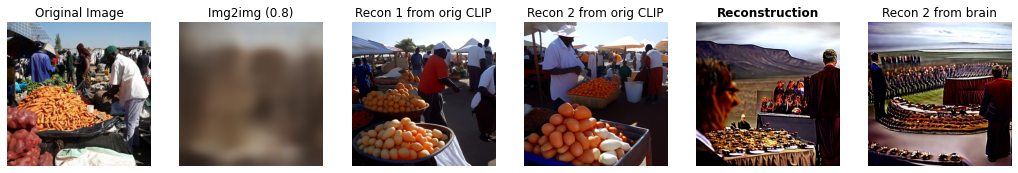

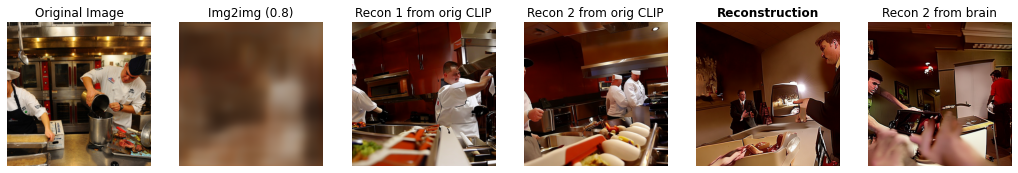

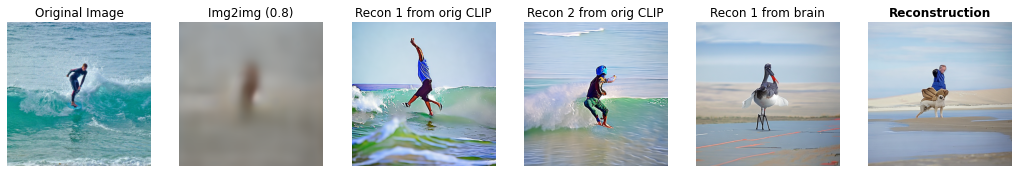

In [10]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
all_laion_picks = None

recons_per_clip = 2
recons_per_brain = 2

img2img = True
retrieve = False
plotting = True

batch_size = 1
assert batch_size == 1

for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val)):
    voxel = torch.mean(voxel,axis=1).to(device)
    # voxel = voxel[:,0].to(device)
    img = img[[0]]
    with torch.no_grad():
        if img2img:
            ae_preds = voxel2sd(voxel.float())
            blurry_recons = vae.decode(ae_preds.to(device)/0.18215).sample / 2 + 0.5
        else:
            blurry_recons = None
        
        grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_openclip(
            img, voxel,
            voxel2clip, 
            clip_extractor, unet, vae, noise_scheduler,
            prompt_embeds0,
            img_lowlevel = blurry_recons,
            num_inference_steps = num_inference_steps,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .8, # 0=fully rely on img_lowlevel, 1=not doing img2img
            timesteps = 1000,
            seed = seed,
            retrieve = retrieve,
            plotting = plotting,
        )

        if plotting:
            grid.savefig(f'evals/{model_name}_{val_i}_{scheduler}_reimagine.png')
            #plt.close()

        if clip_recons is not None:
            clip_recons = clip_recons[:,0]
        if brain_recons is not None:
            brain_recons = brain_recons[:,int(laion_best_picks)]

        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            if recons_per_brain > 0 or retrieve:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            if recons_per_clip > 0:
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))
    if val_i>=2:
        break
                    
if recons_per_brain > 0 or retrieve:
    if recons_per_brain>0:
        all_brain_recons = all_brain_recons.view(-1,3,512,512)
    else:
        all_brain_recons = all_brain_recons.view(-1,3,512,512)
if recons_per_clip > 0:
    all_clip_recons = all_clip_recons.view(-1,3,512,512)

print("all_images.shape",all_images.shape)
if recons_per_brain > 0 or retrieve:
    print("all_brain_recons.shape",all_brain_recons.shape)
if recons_per_clip > 0: 
    print("all_clip_recons.shape",all_clip_recons.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [16]:
from diffusers.utils import randn_tensor
from utils import torch_to_Image

# voxel = torch.mean(voxel,axis=1).to(device)
# img = img[[0]]

image=img
img_lowlevel = blurry_recons
num_inference_steps = 50
n_samples_save = 1
recons_per_clip = 2
recons_per_brain = 2
guidance_scale = 7.5
img2img_strength = .6
timesteps = 1000
seed = 0
retrieve=False
plotting=True

def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

voxel=voxel[:n_samples_save]
image=image[:n_samples_save]

do_classifier_free_guidance = guidance_scale > 1.0
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor
generator = torch.Generator(device=device)
generator.manual_seed(seed)

# Prep CLIP-Image embeddings for original image for comparison with reconstructions
if recons_per_clip > 0:
    clip_embeddings = clip_extractor.embed_image(image).float()
else:
    clip_embeddings = torch.Tensor([])

voxel2clip.eval()
brain_clip_embeddings = brain_clip_embeddings0 = voxel2clip(voxel.to(device).float())

with torch.no_grad():
    # Now enter individual image processing loop
    clip_recons = None
    brain_recons = None
    img2img_refs = None
    for e, emb in enumerate([clip_embeddings, brain_clip_embeddings]):
        if e==0:
            embed_type = 'clip'
        else:
            embed_type = 'brain'
        for emb_idx, input_embedding in enumerate(emb):
            if embed_type == 'clip':
                recons_per_sample = recons_per_clip
            else:
                recons_per_sample = recons_per_brain
            if embed_type == "brain" and retrieve:
                image_retrieved0 = query_laion(emb=brain_clip_embeddings0.float().detach().cpu().numpy().flatten(),groundtruth=image[0])
                if embed_type == "brain" and retrieve and recons_per_brain>0:
                    image_retrieved = (image_retrieved0[0] + 1) / 2
                    retrieved_clip = clip_extractor.embed_image(image_retrieved).float()

            if recons_per_clip == 0 and embed_type =='clip':
                continue
            elif recons_per_brain == 0 and embed_type =='brain' and retrieve:
                if brain_recons is None:
                    brain_recons = image_retrieved0[None]
                else:
                    brain_recons = torch.vstack((brain_recons,image_retrieved0[None]))
                brain_recons.to(device)
                continue
                
            image_embeds = torch.cat((input_embedding, input_embedding)).unsqueeze(0)

            if do_classifier_free_guidance:
                negative_prompt_embeds = torch.zeros_like(image_embeds)
                image_embeds = torch.cat([negative_prompt_embeds, image_embeds])

            # image_embeds = sd_pipe.noise_image_embeddings(
            #     image_embeds=input_embedding,
            #     noise_level=0, #0 to 1000
            # )
            
            # prompt_embeds = sd_pipe._encode_prompt(
            #     prompt="",
            #     device=device,
            #     num_images_per_prompt=recons_per_sample,
            #     do_classifier_free_guidance=True,
            #     negative_prompt="",
            # )
            
            input_embedding = input_embedding.repeat(recons_per_sample, 1)
            input_embedding = torch.cat([torch.zeros_like(input_embedding), input_embedding]).unsqueeze(1).to(device)
            
            image_embeds = input_embedding.repeat(1,1,2).squeeze(1)
            prompt_embeds = prompt_embeds0.repeat(image_embeds.shape[0], 1, 1).float()

            # 4. Prepare timesteps
            noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps, device=device)

            # 5b. Prepare latent variables
            batch_size = input_embedding.shape[0] // 2 # divide by 2 bc we doubled it for classifier-free guidance
            shape = (batch_size, unet.in_channels, height // vae_scale_factor, width // vae_scale_factor)
            if (embed_type == "brain") and (img_lowlevel is not None): # use img_lowlevel for img2img initialization
                img_lowlevel = img_lowlevel[:n_samples_save]
                # img_lowlevel = transforms.functional.gaussian_blur(img_lowlevel,kernel_size=41)
                # img_lowlevel = image_retrieved.float()
                # img_lowlevel = nn.functional.interpolate(img_lowlevel, 512, mode="area", antialias=False).to(device)

                init_timestep = min(int(num_inference_steps * img2img_strength), num_inference_steps)
                t_start = max(num_inference_steps - init_timestep, 0)
                timesteps = noise_scheduler.timesteps[t_start:]
                latent_timestep = timesteps[:1].repeat(batch_size)

                if img2img_refs is None:
                    img2img_refs = img_lowlevel[[emb_idx]]
                elif img2img_refs.shape[0] <= emb_idx:
                    img2img_refs = torch.cat((img2img_refs, img_lowlevel[[emb_idx]]))
                img_lowlevel_embeddings = clip_extractor.preprocess(img_lowlevel[[emb_idx]])
                
                img_lowlevel_embeddings = nn.functional.interpolate(img_lowlevel_embeddings, 
                                                                   (768,768), mode="area", antialias=False)
                
                init_latents = vae.encode(img_lowlevel_embeddings).latent_dist.sample(generator)
                init_latents = vae.config.scaling_factor * init_latents
                init_latents = init_latents.repeat(recons_per_sample, 1, 1, 1)

                noise = randn_tensor(shape, generator=generator, device=device)
                init_latents = noise_scheduler.add_noise(init_latents, noise, latent_timestep)
                latents = init_latents
            else:
                timesteps = noise_scheduler.timesteps
                latents = randn_tensor(shape, generator=generator, device=device, dtype=input_embedding.dtype)
                latents = latents * noise_scheduler.init_noise_sigma

            # 7. Denoising loop
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

                noise_pred = unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    class_labels=image_embeds,
                    cross_attention_kwargs=None, 
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
            recons = decode_latents(latents).detach().cpu()

            if embed_type == 'clip':
                if clip_recons is None:
                    clip_recons = recons.unsqueeze(0)
                else:
                    clip_recons = torch.cat((clip_recons,recons.unsqueeze(0)))
            elif embed_type == 'brain':
                if brain_recons is None:
                    brain_recons = recons.unsqueeze(0)
                else:
                    brain_recons = torch.cat((brain_recons,recons.unsqueeze(0)))

    # ensure no alpha channel
    brain_recons = brain_recons[:,:,:3]

    # compare CLIP embedding of LAION nearest neighbor to your brain reconstructions
    best_picks = np.zeros(n_samples_save)
    if embed_type == "brain" and (retrieve or img_lowlevel is not None):
        for im in range(n_samples_save):            
            # brain_clips = clip_extractor.embed_image(brain_recons[im])
            # cos_sims_to_neighbor = batchwise_cosine_similarity(brain_clips.float(), retrieved_clip)
            # best_picks[im] = int(torch.argmax(cos_sims_to_neighbor))

            # prevent a blank image from being selected
            for ii in range(len(brain_recons[im])):
                if torch.all(brain_recons[im][ii]==0):
                    brain_recons[im][ii] *= np.nan

            weights = AlexNet_Weights.DEFAULT
            model = alexnet(weights=weights).eval()
            model.requires_grad_(False)
            preprocess = weights.transforms()
            for i,f in enumerate(model.features):
                if recons_per_brain==0 and retrieve:
                    if i>4: model.features[i] = nn.Identity() # mid
                else:
                    if i>1: model.features[i] = nn.Identity() # early
            model.avgpool=nn.Identity()
            model.classifier=nn.Identity()
            model.to(img_lowlevel.device)

            brain_recons = brain_recons.to(img_lowlevel.device)
            with torch.cuda.amp.autocast(False): # tendency to go infinity if using half()
                pix_dist = None
                img_lowlevel_alex = model(preprocess(img_lowlevel[[0]]))
                for ii in range(len(brain_recons[im])):
                    recon_alex = model(preprocess(brain_recons[im][[ii]])) 
                    cos_dist = pairwise_cosine_similarity(img_lowlevel_alex,recon_alex).item()
                    if pix_dist is None:
                        pix_dist = cos_dist
                    else:
                        pix_dist = np.hstack((pix_dist, cos_dist))
                best_picks[im] = int(np.nanargmax(pix_dist))
    best_picks = best_picks.astype(np.int8)

    if recons_per_brain==0 and retrieve:
        recon_is_laion = True
        recons_per_brain = 1 # brain reconstruction will simply be the LAION nearest neighbor
    else:
        recon_is_laion = False

    img2img_samples = 0 if img_lowlevel is None else 1
    laion_samples = 1 if retrieve else 0
    num_xaxis_subplots = 1+img2img_samples+laion_samples+recons_per_clip+recons_per_brain
    if plotting:
        fig, ax = plt.subplots(n_samples_save, num_xaxis_subplots, 
                           figsize=(num_xaxis_subplots*3,4.5*n_samples_save),
                           facecolor=(1, 1, 1))
    else:
        fig = None
    if n_samples_save > 1:
        for im in range(n_samples_save):
            if plotting:
                ax[im][0].set_title(f"Original Image")
                ax[im][0].imshow(torch_to_Image(image[im]))
                if img2img_samples == 1:
                    ax[im][1].set_title(f"Img2img ({img2img_strength})")
                    ax[im][1].imshow(torch_to_Image(img_lowlevel[im]))
                    # ax[im][1].imshow(torch_to_Image(img2img_refs[im]))
            for ii,i in enumerate(range(num_xaxis_subplots-laion_samples-recons_per_clip-recons_per_brain,num_xaxis_subplots-laion_samples-recons_per_brain)):
                recon = clip_recons[im][ii]
                if plotting:
                    ax[im][i].set_title(f"Recon {ii+1} from orig CLIP")
                    ax[im][i].imshow(torch_to_Image(recon))
            for ii,i in enumerate(range(num_xaxis_subplots-laion_samples-recons_per_brain,num_xaxis_subplots-laion_samples)):
                recon = brain_recons[im][ii]
                if recon_is_laion:
                    recon = brain_recons[im][best_picks[0]]
                if plotting:
                    if ii == best_picks[im]:
                        ax[im][i].set_title(f"Reconstruction",fontweight='bold')
                    else:
                        ax[im][i].set_title(f"Recon {ii+1} from brain")
                    ax[im][i].imshow(torch_to_Image(recon))
            if plotting:
                if retrieve and not recon_is_laion:
                    ax[im][-1].set_title(f"LAION5b top neighbor")
                    ax[im][-1].imshow(torch_to_Image(image_retrieved0))
                for i in range(num_xaxis_subplots):
                    ax[im][i].axis('off')
    else:   
        im = 0
        if plotting:
            ax[0].set_title(f"Original Image")
            ax[0].imshow(torch_to_Image(image[im]))
            if img2img_samples == 1:
                ax[1].set_title(f"Img2img ({img2img_strength})")
                ax[1].imshow(torch_to_Image(img_lowlevel[im]))
                # ax[1].imshow(torch_to_Image(img2img_refs[im]))
        for ii,i in enumerate(range(num_xaxis_subplots-laion_samples-recons_per_clip-recons_per_brain,num_xaxis_subplots-recons_per_brain-laion_samples)):
            recon = clip_recons[im][ii]
            if plotting:
                ax[i].set_title(f"Recon {ii+1} from orig CLIP")
                ax[i].imshow(torch_to_Image(recon))
        for ii,i in enumerate(range(num_xaxis_subplots-laion_samples-recons_per_brain,num_xaxis_subplots-laion_samples)):
            recon = brain_recons[im][ii]
            if recon_is_laion:
                recon = brain_recons[im][best_picks[0]]
            if plotting:
                if ii == best_picks[im]:
                    ax[i].set_title(f"Reconstruction",fontweight='bold')
                else:
                    ax[i].set_title(f"Recon {ii+1} from brain")
                ax[i].imshow(torch_to_Image(recon))
        if plotting:
            if retrieve and not recon_is_laion:
                ax[-1].set_title(f"LAION5b top neighbor")
                ax[-1].imshow(torch_to_Image(image_retrieved0))
            for i in range(num_xaxis_subplots):
                ax[i].axis('off')

NameError: name 'AlexNet_Weights' is not defined

In [15]:
img_lowlevel_embeddings = clip_extractor.preprocess(img_lowlevel[[emb_idx]])

img_lowlevel_embeddings = nn.functional.interpolate(img_lowlevel_embeddings, (768,768), mode="area", antialias=False)

init_latents = vae.encode(img_lowlevel_embeddings).latent_dist.sample(generator)
init_latents = vae.config.scaling_factor * init_latents
init_latents = init_latents.repeat(recons_per_sample, 1, 1, 1)

noise = randn_tensor(shape, generator=generator, device=device)
init_latents = noise_scheduler.add_noise(init_latents, noise, latent_timestep)
latents = init_latents

In [13]:
noise.shape

torch.Size([2, 4, 96, 96])

In [70]:
print(input_embedding.shape)

image_embeds = input_embedding.repeat(recons_per_sample, 1)
print(image_embeds.shape)

image_embeds = torch.cat([torch.zeros_like(image_embeds), image_embeds]).unsqueeze(1).to(device)
image_embeds = image_embeds.repeat(1,1,2)
print(image_embeds.shape)

prompt_embeds = prompt_embeds0.repeat(image_embeds.shape[0],1,1).float()
print(prompt_embeds.shape)

torch.Size([2, 1, 1024])


In [80]:
print(latent_model_input.shape)
print(t)
print(prompt_embeds.shape)
print(image_embeds.shape)

torch.Size([2, 4, 96, 96])
tensor(20, device='cuda:0')
torch.Size([2, 77, 1024])
torch.Size([2, 2048])


In [78]:
print(latent_model_input.shape)
print(t)
print(prompt_embeds.shape)
print(image_embeds.shape)

torch.Size([2, 4, 96, 96])
tensor(999, device='cuda:0')
torch.Size([2, 77, 1024])
torch.Size([2, 1, 2048])


In [66]:
input_embedding.shape

torch.Size([6, 1, 1024])

In [61]:
torch.save(all_brain_recons,'evals/all_brain_recons')
torch.save(all_clip_recons,'evals/all_clip_recons')
torch.save(all_images,'evals/all_images')

The config attributes {'class_embeddings_concat': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/21 [00:00<?, ?it/s]

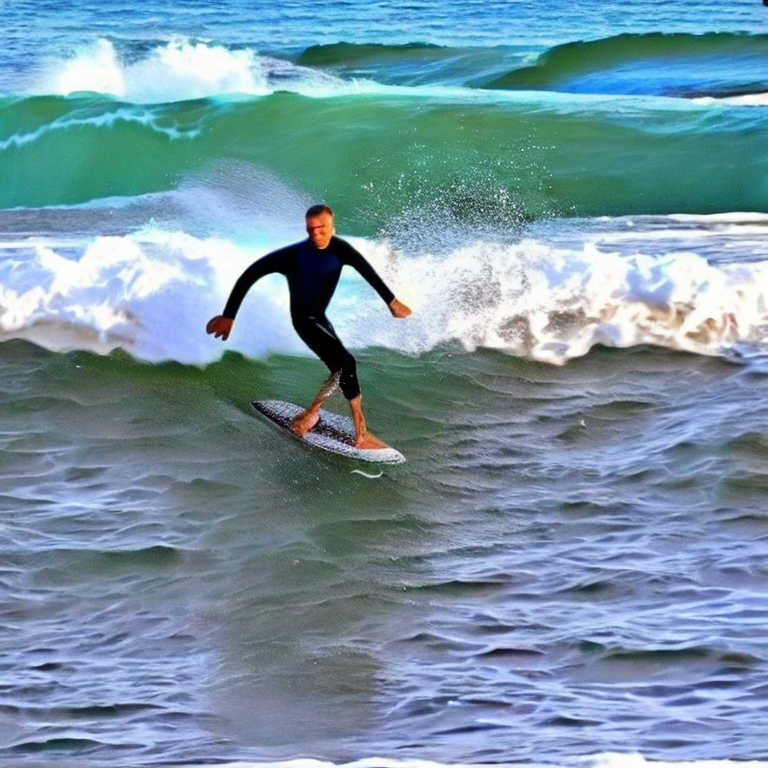

In [31]:
from diffusers import StableUnCLIPImg2ImgPipeline
with torch.no_grad():
    sd_pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
        sd_cache_dir, torch_dtype=torch.float16,
    )
    sd_pipe.to(device)

p=sd_pipe(image=utils.torch_to_Image(img),prompt='surfer')
p[0][0]

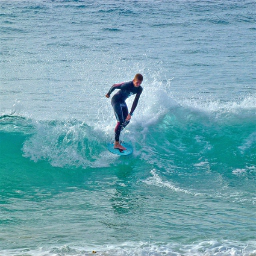

In [29]:
utils.torch_to_Image(img)

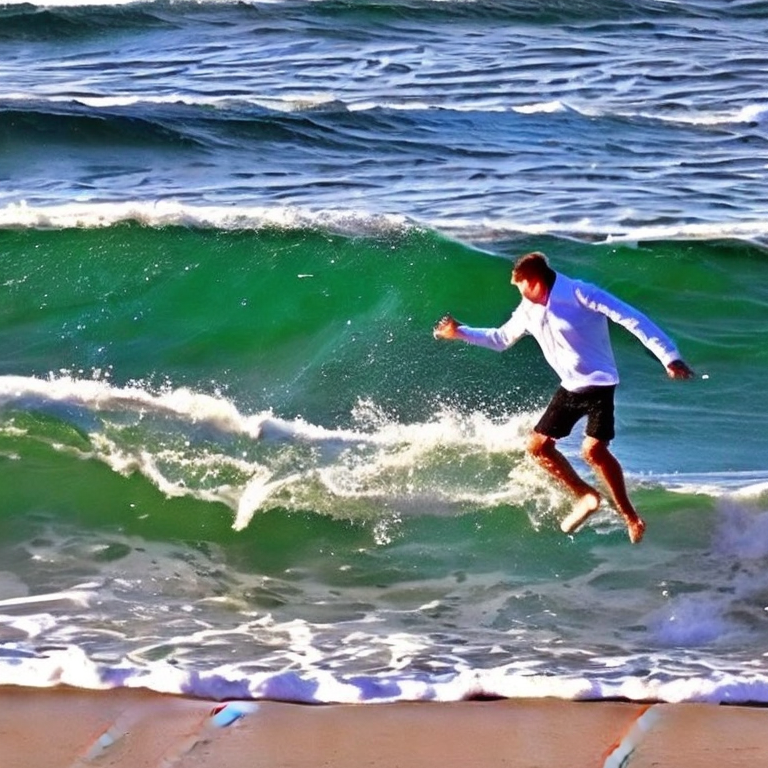

In [30]:
p[0][0]

In [10]:
from diffusers import StableUnCLIPImg2ImgPipeline
with torch.no_grad():
    sd_pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
        sd_cache_dir, torch_dtype=torch.float16,
    )
    sd_pipe.to(device)

#     image_embeds = clip_extractor.embed_image(img).float()
#     print(image_embeds.shape)

#     # 8. Encode input prompt
#     prompt_embeds = sd_pipe._encode_prompt(
#         prompt="",
#         device=device,
#         num_images_per_prompt=2,
#         do_classifier_free_guidance=True,
#         negative_prompt="",
#     )
#     print(prompt_embeds.shape)

#     # 9. Prepare image embeddings
#     image_embeds = sd_pipe.noise_image_embeddings(
#         image_embeds=image_embeds,
#         noise_level=0, #0 to 1000
#     )
#     print(image_embeds.shape)
#     noise_pred = unet(
#         latent_model_input,
#         t,
#         encoder_hidden_states=prompt_embeds,
#         class_labels=image_embeds,
#         cross_attention_kwargs=None, 
#     ).sample

The config attributes {'class_embeddings_concat': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
help(sd_pipe)

Help on StableUnCLIPImg2ImgPipeline in module diffusers.pipelines.stable_diffusion.pipeline_stable_unclip_img2img object:

class StableUnCLIPImg2ImgPipeline(diffusers.pipelines.pipeline_utils.DiffusionPipeline)
 |  StableUnCLIPImg2ImgPipeline(feature_extractor: transformers.models.clip.feature_extraction_clip.CLIPFeatureExtractor, image_encoder: transformers.models.clip.modeling_clip.CLIPVisionModelWithProjection, image_normalizer: diffusers.pipelines.stable_diffusion.stable_unclip_image_normalizer.StableUnCLIPImageNormalizer, image_noising_scheduler: diffusers.schedulers.scheduling_utils.KarrasDiffusionSchedulers, tokenizer: transformers.models.clip.tokenization_clip.CLIPTokenizer, text_encoder: transformers.models.clip.modeling_clip.CLIPTextModel, unet: diffusers.models.unet_2d_condition.UNet2DConditionModel, scheduler: diffusers.schedulers.scheduling_utils.KarrasDiffusionSchedulers, vae: diffusers.models.autoencoder_kl.AutoencoderKL)
 |  
 |  Pipeline for text-guided image to image 

In [35]:
clip_extractor.embed_image(img).float().shape

torch.Size([1, 1024])

# Loading

In [121]:
import torch
from tqdm import tqdm
all_brain_recons = None
for i in tqdm(range(9)):
    j = i * 109 
    d = torch.load(f'evals/brain_recons_{j}_{j+109}',map_location=torch.device('cpu'))
    #d = torch.load(f'evals/retrieval_recons_{j}_{j+109}',map_location=torch.device('cpu'))
    # e = torch.load(f'evals/retrieval_images_{j}_{j+109}',map_location=torch.device('cpu'))

    if all_brain_recons is None:
        all_brain_recons = d
        # all_images = e
    else:
        all_brain_recons = torch.vstack((all_brain_recons, d))
        # all_images = torch.vstack((all_images, e))
print(all_brain_recons.shape)
# print(all_images.shape)
# torch.save(all_images,'evals/all_images')
torch.save(all_brain_recons,'evals/all_brain_retrievals')

100%|███████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.01it/s]

torch.Size([990, 3, 512, 512])


In [130]:
# all_brain_recons = torch.load('evals/all_brain_retrievals')
all_brain_recons = torch.load('evals/all_brain_retrievals')
# all_clip_recons = torch.load('evals/all_clip_recons')
all_images = torch.load('evals/all_images')
# all_laion_picks = torch.load('evals/all_laion_picks')

## FID evaluation
We don't report FID because it's not really appropriate when we have ground truth test images. Still, we already had it implemented so here it is.

In [123]:
import  pytorch_fid_wrapper as pfw

# technically should have >=2048 images to calculate this (which we don't have)... less samples mean worse fid score
dims = 2048

# assert len(fake_images) >= dims

pfw.set_config(batch_size=4, dims=dims, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(all_brain_recons.float(), real_images=all_images.float())
print(val_fid)

/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/home-paulscotti/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


88.90673330325598


## 2-way identification

In [131]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess):
    per_correct = []
    l2dist_list = []
    for irecon, recon in enumerate(all_brain_recons):
        with torch.no_grad():   
            if torch.all(recon==0) or torch.all(recon==1):
                print("skip")
                continue
            real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
            # fake = model(preprocess(transforms.functional.hflip(all_images[irecon]).unsqueeze(0))).float() 
            fake = model(preprocess(recon).unsqueeze(0)).float()

            rand_idx = np.random.randint(len(all_brain_recons))
            while irecon == rand_idx:
                rand_idx = np.random.randint(len(all_brain_recons))
            rand = model(preprocess(all_brain_recons[rand_idx]).unsqueeze(0)).float()

            # l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
            # l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

            # cosine similarity is faster and gives same results
            l2dist_fake = utils.pairwise_cosine_similarity(real,fake).item()
            l2dist_rand = utils.pairwise_cosine_similarity(real,rand).item()

            if l2dist_fake > l2dist_rand:
                per_correct.append(1)
            else:
                per_correct.append(0)
            l2dist_list.append(l2dist_fake)
    return per_correct, l2dist_list

def two_way_identification_clip(all_brain_recons, all_images):
    per_correct = []
    l2dist_list = []
    for irecon, recon in enumerate(all_brain_recons):
        with torch.no_grad():       
            if torch.all(recon==0) or torch.all(recon==1):
                print("skip")
                continue

            real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
            fake = clip_extractor.embed_image(recon.unsqueeze(0)).float()
            rand_idx = np.random.randint(len(all_brain_recons))
            while irecon == rand_idx:
                rand_idx = np.random.randint(len(all_brain_recons))
            rand = clip_extractor.embed_image(all_brain_recons[rand_idx].unsqueeze(0)).float()

            # l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
            # l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

            # cosine similarity is faster and gives same results
            l2dist_fake = utils.pairwise_cosine_similarity(real,fake).item()
            l2dist_rand = utils.pairwise_cosine_similarity(real,rand).item()

            if l2dist_fake > l2dist_rand:
                per_correct.append(1)
            else:
                per_correct.append(0)
            l2dist_list.append(l2dist_fake)
    return per_correct, l2dist_list

### AlexNet

In [133]:
# from torchvision.models import alexnet, AlexNet_Weights

# weights = AlexNet_Weights.DEFAULT
# model = alexnet(weights=weights).eval()
# model.requires_grad_(False)
# preprocess = weights.transforms()

# for layer in ['late','mid','early']: # corresponds to layers used in Takagi & Nishimoto
#     for i,f in enumerate(model.features):
#         if layer=='early' and i>1:
#             model.features[i] = nn.Identity()
#         elif layer=='mid' and i>4:
#             model.features[i] = nn.Identity()
#         elif layer=='late' and i>7:
#             model.features[i] = nn.Identity()
#     model.avgpool=nn.Identity()
#     model.classifier=nn.Identity()
    
#     if layer == 'late':
#         all_alex_early = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
#     elif layer =='mid':
#         all_alex_mid = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
#     else:
#         all_alex_late = model(preprocess(all_images[irecon]).unsqueeze(0)).float()


### Preloaded image features

### Eval on recons

In [134]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
model.requires_grad_(False)
preprocess = weights.transforms()

layer = 'late'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(model)
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.4f} | {np.std(all_per_correct):.4f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

layer = 'mid'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(model)
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.4f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

layer = 'early'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(model)
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.4f} | {np.std(all_per_correct):.4f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): Identity()
    (10): Identity()
    (11): Identity()
    (12): Identity()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, ou

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x13824 and 9216x4096)

### InceptionV3

In [135]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
model.requires_grad_(False)
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
# print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.4f} | {np.std(all_per_correct):.4f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

2-way Percent Correct (mu, std): 0.8687 | 0.3377
Avg l2dist_fake (mu, std): 0.6167 | 0.1105


### CLIP

In [136]:
all_per_correct, all_l2dist_list = two_way_identification_clip(all_brain_recons, all_images)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.4f} | {np.std(all_per_correct):.4f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

2-way Percent Correct (mu, std): 0.9111 | 0.2846
Avg l2dist_fake (mu, std): 0.6964 | 0.0964


## SSIM

In [40]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(img[0].permute((1,2,0)))
recon_gray = rgb2gray(img[0].permute((1,2,0)))

ssim_score = ssim(img_gray, recon_gray, multichannel=True, gaussian_weights=True, 
                      sigma=1.5, use_sample_covariance=False, data_range=1.0)
ssim_score

1.0

## PixCorr

In [12]:
## insert pixcorr code here
pix_dist = torch.hstack((pix_dist, torch.corrcoef(torch.vstack((brain_recons[im][ii].flatten(), 
                        img_lowlevel[0].detach().cpu().flatten())))[0][1]))


# UMAP

## Get CLIP embeddings

In [268]:
# # load annotations for coco73k
# annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")

# batch_size = 64 # increasing it doesnt really speed things up for this 

# train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
# val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
# meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
# num_train = 8559 + 300
# num_val = 982

# # train_data = wds.WebDataset(train_url, resampled=False)\
# #     .decode("torch")\
# #     .rename(images="jpg;png", voxels='nsdgeneral.npy', trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
# #     .to_tuple("voxels", "images", "coco")\
# #     .batched(batch_size, partial=True)

# # train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, shuffle=False)

# val_data = wds.WebDataset(train_url, resampled=False)\
#     .decode("torch")\
#     .rename(images="jpg;png", voxels='nsdgeneral.npy', trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
#     .to_tuple("voxels", "images", "coco")\
#     .batched(batch_size, partial=True)

# val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# clip_texts = None
# clip_images = None
# clip_brains = None
# clip_brains_aligned = None

# generator = torch.Generator(device=device)
# generator.manual_seed(seed)

# for train_i, (voxel, image, coco) in enumerate(tqdm(val_dl,total=num_val//batch_size)):
#     text = utils.select_annotations(annots[coco], random=False)
#     text_emb = clip_extractor.embed_text(text).float()
    
#     image_emb = clip_extractor.embed_image(image).float()
    
#     voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions
#     voxel_emb = nn.functional.normalize(diffusion_prior.voxel2clip(voxel.float()),dim=-1) * diffusion_prior.image_embed_scale
    
#     voxel_emb_aligned = diffusion_prior.p_sample_loop(voxel_emb.shape, 
#                             text_cond = dict(text_embed = voxel_emb), 
#                             cond_scale = 1., timesteps = 1000, generator=generator,
#                             )
    
#     if clip_texts is None or clip_images is None:
#         clip_texts = text_emb
#         clip_images = image_emb
#         clip_brains = voxel_emb
#         clip_brains_aligned = voxel_emb_aligned
#     else:
#         clip_texts = torch.vstack((clip_texts, text_emb))
#         clip_images = torch.vstack((clip_images, image_emb))       
#         clip_brains = torch.vstack((clip_brains, voxel_emb))       
#         clip_brains_aligned = torch.vstack((clip_brains_aligned, voxel_emb_aligned))       
# print("clip_texts.shape",clip_texts.shape)
# print("clip_images.shape",clip_images.shape)
# print("clip_brains.shape",clip_brains.shape)
# print("clip_brains_aligned.shape",clip_brains_aligned.shape)

# np.save("clip_texts",clip_texts.detach().cpu().numpy())
# np.save("clip_images",clip_images.detach().cpu().numpy())
# np.save("clip_brains",clip_brains.detach().cpu().numpy())
# np.save("clip_brains_aligned",clip_brains_aligned.detach().cpu().numpy())

# print("Done!")    

In [11]:
clip_texts = np.load("clip_texts.npy")
clip_images = np.load("clip_images.npy")
clip_brains = np.load("clip_brains.npy")
clip_brains_aligned = np.load("clip_brains_aligned.npy")

print("clip_texts.shape",clip_texts.shape)
print("clip_images.shape",clip_images.shape)
print("clip_brains.shape",clip_brains.shape)
print("clip_brains_aligned.shape",clip_brains_aligned.shape)

clip_texts.shape (1088, 768)
clip_images.shape (1088, 768)
clip_brains.shape (1088, 768)
clip_brains_aligned.shape (1088, 768)


combined.shape (2176, 768)
blue = CLIP-Image
orange = CLIP-text
green = CLIP-brain


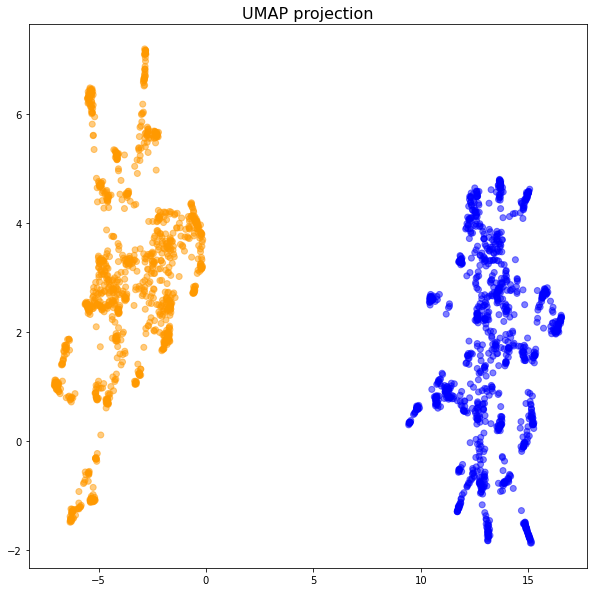

In [147]:
combined = np.concatenate((clip_texts,clip_images),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
colors=np.concatenate((colors, np.array([[1,.6,0,.5] for i in range(len(clip_texts))])))
# colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_brains))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_text_image.png')
plt.show()

combined.shape (2176, 768)


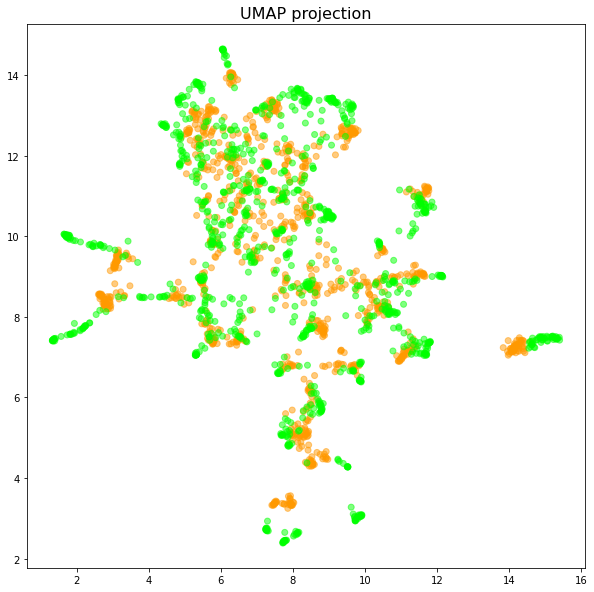

In [152]:
combined = np.concatenate((clip_texts,clip_brains),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

# colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
colors=np.array([[1,.6,0,.5] for i in range(len(clip_texts))])
colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_brains))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_text_brain.png')
plt.show()

combined.shape (2176, 768)


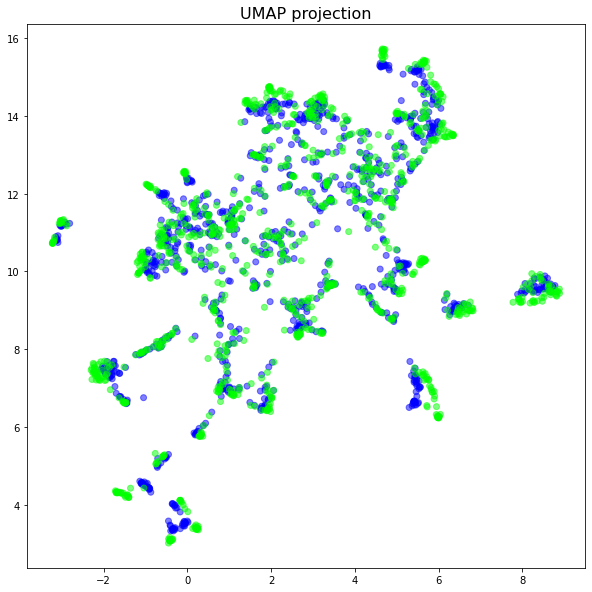

In [148]:
combined = np.concatenate((clip_images,clip_brains),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
# colors=np.concatenate((colors, np.array([[1,.6,0,.5] for i in range(len(clip_texts))])))
colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_brains))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_image_brain.png')
plt.show()

combined.shape (2176, 768)


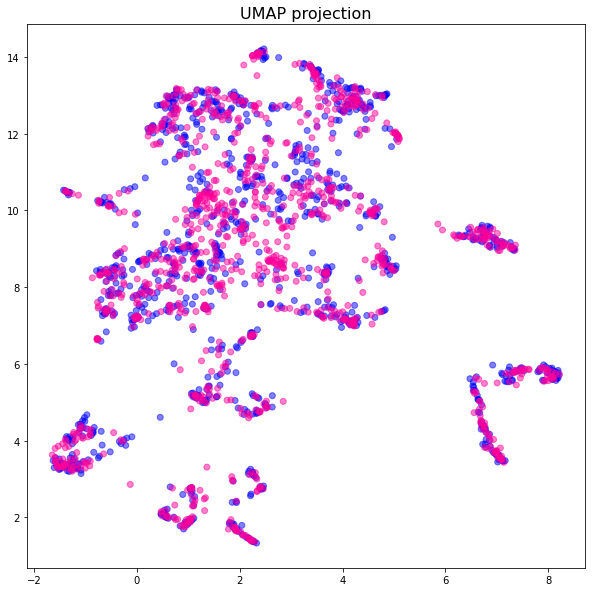

In [149]:
combined = np.concatenate((clip_images,clip_brains_aligned),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
# colors=np.concatenate((colors, np.array([[1,.6,0,.5] for i in range(len(clip_texts))])))
colors=np.concatenate((colors, np.array([[1,0,.6,.5] for i in range(len(clip_brains_aligned))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_image_brain-aligned.png')
plt.show()

combined.shape (2176, 768)


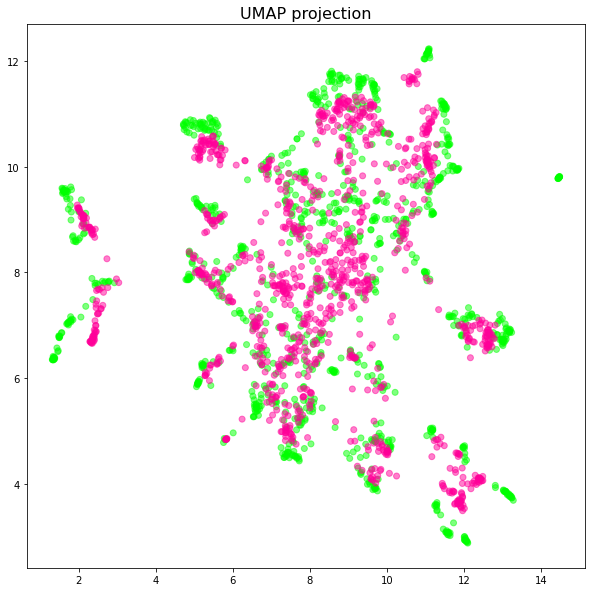

In [150]:
combined = np.concatenate((clip_brains,clip_brains_aligned),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

colors=np.array([[0,1,0,.5] for i in range(len(clip_brains))])
colors=np.concatenate((colors, np.array([[1,0,.6,.5] for i in range(len(clip_brains_aligned))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_brain_brain-aligned.png')
plt.show()

combined.shape (3264, 768)


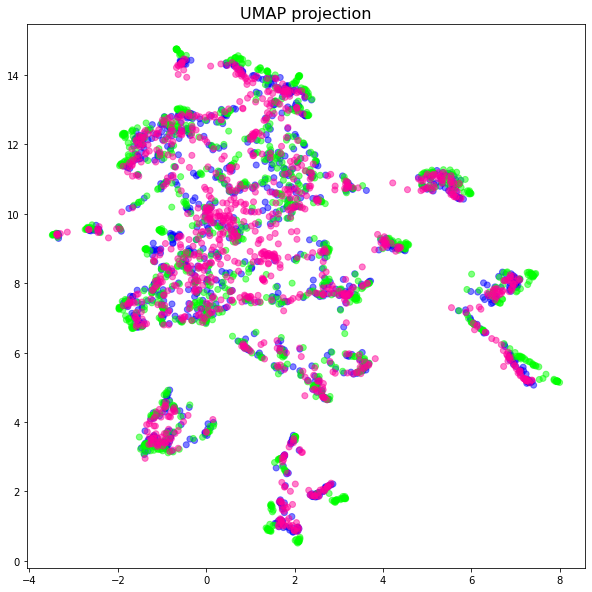

In [13]:
combined = np.concatenate((clip_images,clip_brains,clip_brains_aligned),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(combined)

colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_brains))])))
colors=np.concatenate((colors, np.array([[1,0,.6,.5] for i in range(len(clip_brains_aligned))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_image_brain_brain-aligned.png')
plt.show()

In [ ]:
combined = np.concatenate((clip_images,clip_texts,clip_brains),axis=0)
print("combined.shape",combined.shape)

reducer = umap.UMAP()
embedding = reducer.fit_transform(combined)

colors=np.array([[0,0,1,.5] for i in range(len(clip_images))])
colors=np.concatenate((colors, np.array([[1,.6,0,.5] for i in range(len(clip_texts))])))
colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_brains))])))

plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors)
plt.title('UMAP projection',fontsize=16)
plt.savefig(f'UMAP_text_image_brain.png')
plt.show()